## **Individual Analysis of Biometric Dataset**

In [2]:
import os 
from glob import glob
import pandas as pd

In [3]:
BASE_PATH = 'data'
demo_path = os.path.join(BASE_PATH, 'demographic')

In [4]:
def load_folder(folder_path):
    files = glob(os.path.join(folder_path, "*.csv"))
    print(f"Found {len(files)} files in {folder_path}")
    
    df_list = []
    for f in files:
        temp = pd.read_csv(f)
        df_list.append(temp)
    
    return pd.concat(df_list, ignore_index=True)

In [7]:
demo_df = load_folder(demo_path)
print(f"Demographic DataFrame shape: {demo_df.shape}")

#demo_df.to_csv('demographic_data.csv', index=False)

Found 5 files in data\demographic
Demographic DataFrame shape: (2071700, 6)


In [8]:
demo_df['total_demo_updates'] = (
    demo_df['demo_age_5_17'] + 
    demo_df['demo_age_17_']
)

In [9]:
# Stats
print(demo_df.describe())
total_demo_updates = demo_df['total_demo_updates'].sum()  


            pincode  demo_age_5_17  demo_age_17_  total_demo_updates
count  2.071700e+06   2.071700e+06  2.071700e+06        2.071700e+06
mean   5.278318e+05   2.347552e+00  2.144701e+01        2.379456e+01
std    1.972933e+05   1.490355e+01  1.252498e+02        1.381999e+02
min    1.000000e+05   0.000000e+00  0.000000e+00        0.000000e+00
25%    3.964690e+05   0.000000e+00  2.000000e+00        3.000000e+00
50%    5.243220e+05   1.000000e+00  6.000000e+00        7.000000e+00
75%    6.955070e+05   2.000000e+00  1.500000e+01        1.700000e+01
max    8.554560e+05   2.690000e+03  1.616600e+04        1.694200e+04


In [10]:
# Aggregate by district (finer grain)
district_demo = demo_df.groupby('district').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum'
}).reset_index()
district_demo['total_demo'] = district_demo['demo_age_5_17'] + district_demo['demo_age_17_']
district_demo['youth_ratio'] = district_demo['demo_age_5_17'] / district_demo['total_demo']

Standardizing the names

In [25]:
def normalize_state_text(s):
    if pd.isna(s):
        return s
    return (
        s.strip()
         .lower()
         .replace("&", "and")
         .replace("  ", " ")
    )

demo_df["state_clean"] = demo_df["state"].apply(normalize_state_text)
STATE_NAME_MAPPING = {
    # Andaman & Nicobar Islands
    "andaman and nicobar islands": "Andaman & Nicobar Islands",

    # Andhra Pradesh
    "andhra pradesh": "Andhra Pradesh",

    # Dadra and Nagar Haveli and Daman and Diu
    "dadra and nagar haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "the dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",

    # Jammu and Kashmir
    "jammu and kashmir": "Jammu and Kashmir",

    # Odisha
    "odisha": "Odisha",
    "orissa": "Odisha",

    # Puducherry
    "puducherry": "Puducherry",
    "pondicherry": "Puducherry",

    # West Bengal
    "west bengal": "West Bengal",
    "westbengal": "West Bengal",
    "west bangal": "West Bengal",
    "west bengli": "West Bengal",
    
    #Chattisgarh
    "chhattisgarh": "Chhattisgarh",
    "chhatisgarh": "Chhattisgarh",
}

def standardize_state_name(clean_name):
    return STATE_NAME_MAPPING.get(clean_name, clean_name.title())

demo_df["state_standardized"] = demo_df["state_clean"].apply(standardize_state_name)

demo_df["state"] = demo_df["state_standardized"]
demo_df = demo_df.drop(columns=["state_clean", "state_standardized"])
demo_df = demo_df[demo_df['state'] != "100000"].copy()

In [23]:
demo_df.head(10)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,total_demo_updates
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529,578
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375,397
2,01-03-2025,Gujarat,Rajkot,360006,65,765,830
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314,338
4,01-03-2025,Rajasthan,Udaipur,313801,45,785,830
5,01-03-2025,Rajasthan,Sikar,332028,28,285,313
6,01-03-2025,Karnataka,Tumakuru,572201,88,332,420
7,01-03-2025,Uttar Pradesh,Gorakhpur,273211,61,836,897
8,01-03-2025,Andhra Pradesh,Kurnool,518313,83,986,1069
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,294


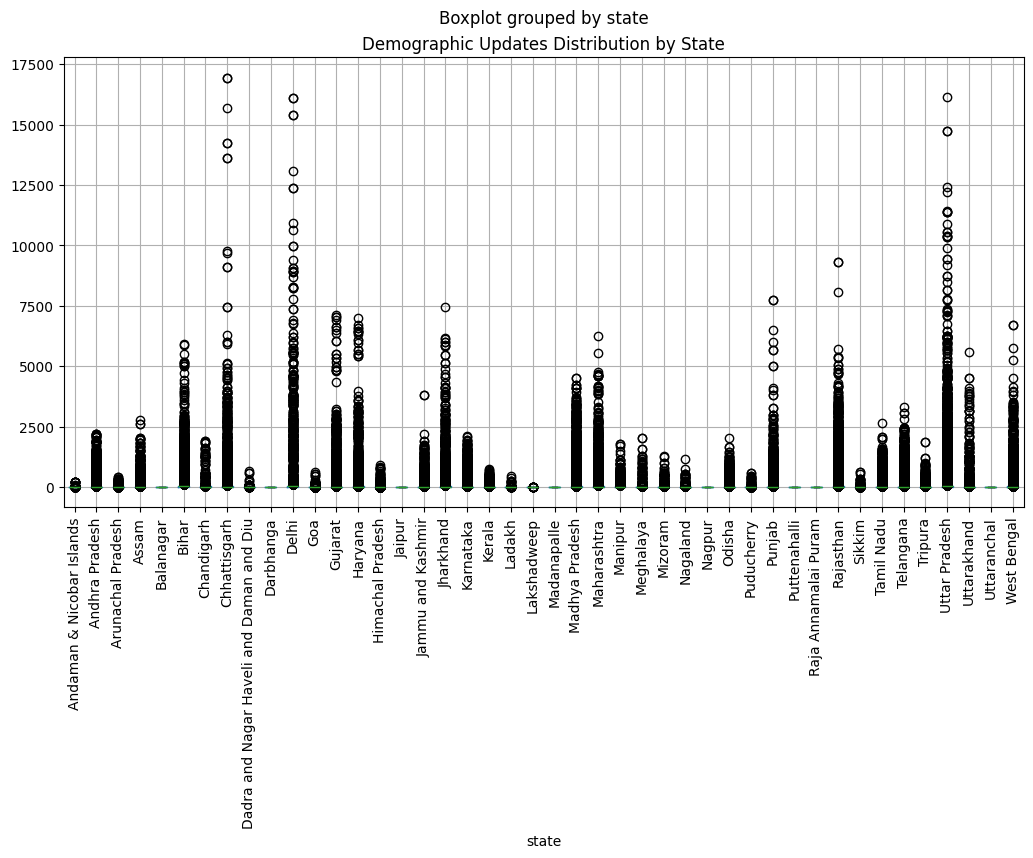

In [26]:
import matplotlib.pyplot as plt
demo_df.boxplot(column='total_demo_updates', by='state', rot=90, figsize=(12,6))
plt.title('Demographic Updates Distribution by State')
plt.show()

Insights:
1. **Skew Toward Populous States**: 80–90% of updates likely come from top 5–7 states (Pareto principle), mirroring enrolment trends. Youth updates (demo_5_17) may dominate in states like Bihar (family moves for education).
2. **Outliers as Anomalies**: Frequent high outliers in northern states indicate "update hotspots"—e.g., urban slums or industrial districts with address volatility.
3. **Link to DDI**: States with wide spreads (e.g., Uttar Pradesh) have higher mean DDI, implying demographic instability from socio-economic factors.
4. **UIDAI Implications**: Focus infrastructure on volatile states (e.g., more ASKs in Mumbai/Pune for Maharashtra migrants). Targeted campaigns in low states could boost inclusion. Cross with time-series: If spikes align with monsoon, weather-proof centres needed.

In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics  

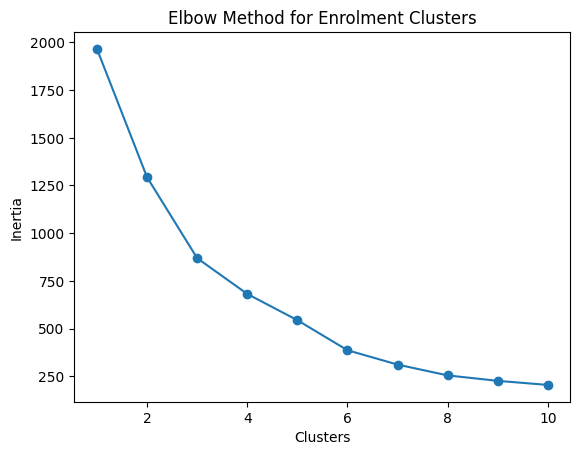

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = district_demo[['total_demo', 'youth_ratio']]
scaled_features = scaler.fit_transform(features.fillna(0))  

# Elbow 
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Enrolment Clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()  

# K-Means (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
district_demo['cluster'] = kmeans.fit_predict(scaled_features)

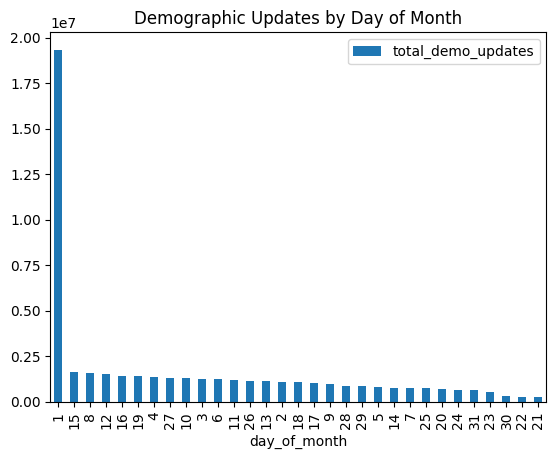

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' is datetime
demo_df['date'] = pd.to_datetime(demo_df['date'], format='%d-%m-%Y')

# Day of Month
demo_df['day_of_month'] = demo_df['date'].dt.day
day_demo = demo_df.groupby('day_of_month')['total_demo_updates'].sum().reset_index().sort_values('total_demo_updates', ascending=False)
day_demo.plot(kind='bar', x='day_of_month', y='total_demo_updates', title='Demographic Updates by Day of Month')
plt.show()

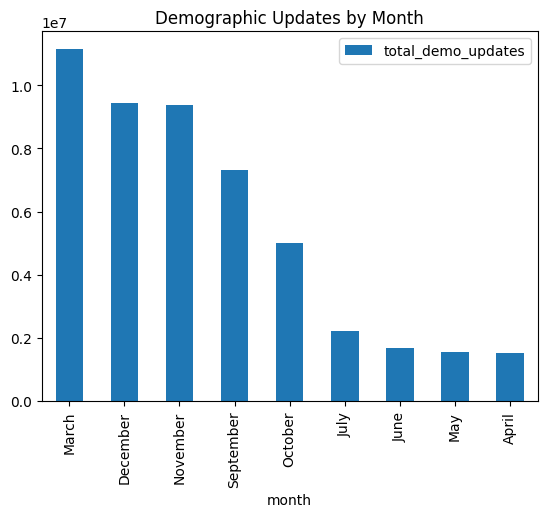

In [35]:
# Month
demo_df['month'] = demo_df['date'].dt.month_name()
month_demo = demo_df.groupby('month')['total_demo_updates'].sum().reset_index().sort_values('total_demo_updates', ascending=False)
month_demo.plot(kind='bar', x='month', y='total_demo_updates', title='Demographic Updates by Month')
plt.show()

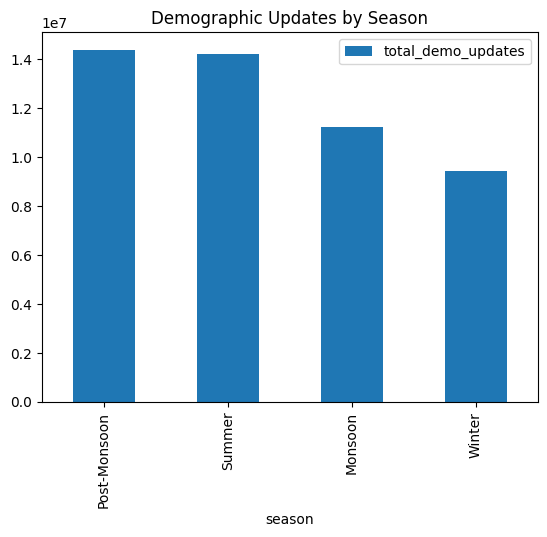

In [37]:
# Season (custom function from before)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

demo_df['month_num'] = demo_df['date'].dt.month
demo_df['season'] = demo_df['month_num'].apply(get_season)
season_demo = demo_df.groupby('season')['total_demo_updates'].sum().reset_index().sort_values('total_demo_updates', ascending=False)
season_demo.plot(kind='bar', x='season', y='total_demo_updates', title='Demographic Updates by Season')
plt.show()